## Project Motivation
Social media platforms like Twitter are often the first source of disaster-related information, sometimes even before official news outlets respond. A system that can intelligently detect whether a tweet refers to a real emergency could potentially save lives by alerting authorities faster.

To address this, we aim to build a machine learning model that classifies tweets as either real disaster reports or unrelated content.


### **Dataset**

We use a publicly available dataset from Kaggle consisting of approximately 10,000 labeled tweets.

- **Target variable**: `target`  
  - `1` = Disaster  
  - `0` = Not a disaster  
- **Feature used**: The tweet text only (`text`)

## Setup

In this section, we import all necessary Python libraries for data processing, NLP, machine learning, and evaluation. We also mount Google Drive to access external data.


In [ ]:
!pip install --upgrade --force-reinstall "numpy<2" "pandas" "scikit-learn" "pyarrow<15"



  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
  Using cached pyarrow-14.0.2-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 37.2 MB/s eta 0:00:00
Using cached pyarrow-14.0.2-cp312-cp312-manylinux_2_28_x86_64.whl (38.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 11.9 MB/s eta 0:00:00
   

In [ ]:
import numpy as np
import pandas as pd
import random
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


## Load the Data

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/NLP/Kopie von train.csv")

df.head()


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


⚠️ **Note**: We can observe that the dataset is not randomly shuffled. The entries appear to be grouped by the `target` label.  Before splitting the data into training and test sets, we must shuffle the dataset to ensure a balanced and representative distribution.


## Overview

In [ ]:
df['target'].value_counts()


,count
target,
0,4342
1,3271


<Axes: title={'center': 'Disaster vs Non-Disaster'}, xlabel='target'>

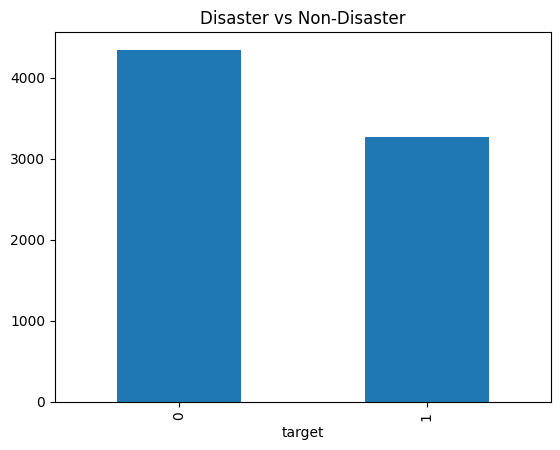

In [ ]:
df['target'].value_counts().plot(kind='bar', title='Disaster vs Non-Disaster')


📊 **Class Distribution Insight**

As shown in the bar chart above, the dataset is imbalanced:  
there are more non-disaster tweets (`target = 0`) than disaster tweets (`target = 1`).  
This class imbalance may affect model performance and should be taken into account when evaluating metrics like accuracy.


## Preprocessing

We define a custom `clean_text()` function to preprocess the tweet content.  
The steps include:

- Lowercasing all characters
- Removing URLs and non-letter characters
- Reducing multiple spaces to single spaces
- Removing English stopwords (e.g., "the", "is", "and", ...)
- Lemmatizing the remaining words using `WordNetLemmatizer` (as verbs)

The cleaned output is saved in a new column called `"clean_text"`, which we will use as input for vectorization and modeling.


In [ ]:
nltk.download('omw-1.4')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    text = re.sub(r"http\S+|www\S+", "", text)

    text = re.sub(r"[^a-zA-Z\s]", "", text)

    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    words = [lemmatizer.lemmatize(w, pos='v') for w in words if w not in stop_words]

    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Shuffle, Split & Vectorize



In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 6090
Test size: 1523


In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


print("TF-IDF fertig. Feature Count =", X_train_tfidf.shape[1])

TF-IDF fertig. Feature Count = 12959


## Baseline Training & Evaluation

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver="saga")
log_reg.fit(X_train_tfidf, y_train)
y_pred_logreg = log_reg.predict(X_test_tfidf)

print("\n===== Logistic Regression =====")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))


svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("\n===== Linear SVC =====")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))



===== Logistic Regression =====
Accuracy: 0.7997373604727511
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Confusion Matrix:
 [[770  99]
 [206 448]]

===== Linear SVC =====
Accuracy: 0.7944845699277742
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       869
           1       0.77      0.74      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523

Confusion Matrix:
 [[729 140]
 [173 481]]


🔴 **Recall for Class 1 (Disaster) is still too low**

In this project, high recall for class `1` (real disasters) is critical — we want to avoid missing actual emergencies.  
Current results:
- Logistic Regression: **Recall = 0.69**
- Linear SVC: **Recall = 0.74**

These values are not yet sufficient for our goal.


## Hyperparameter Tuning

We test multiple `ngram_range` values and regularization strengths for Logistic Regression and Linear SVC.  
Goal: find the best model setup (based on 5-fold cross-validated **F1-score** on class `1`)  
We then retrain the best model on the full training data and evaluate it on the test set.


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

vectorizer_params = [(1,1), (1,2), (1,3)]
logreg_params = [{'model': LogisticRegression(max_iter=1000, C=c, solver='liblinear'), 'name': f"LogReg_C={c}"}
                 for c in [0.1, 1, 3]]
svc_params = [{'model': LinearSVC(C=c), 'name': f"LinearSVC_C={c}"}
              for c in [0.1, 1, 3]]

model_configs = logreg_params + svc_params

best_score = -1
best_setup = None

for ngram in vectorizer_params:
    print(f"\n=== Testing ngram={ngram} ===")

    vectorizer = TfidfVectorizer(ngram_range=ngram)
    X_train_tfidf = vectorizer.fit_transform(X_train)

    for config in model_configs:
        model = config['model']
        name = config['name']

        f1_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1')
        avg_f1 = np.mean(f1_scores)

        print(f"{name} → F1={avg_f1:.4f}")

        if avg_f1 > best_score:
            best_score = avg_f1
            best_setup = (name, ngram, model, vectorizer)

print("\n✅ Best Model Found:")
print(f"Model: {best_setup[0]}")
print(f"ngram_range: {best_setup[1]}")
print(f"F1-Score: {best_score:.4f}")

final_vectorizer = best_setup[3]
final_model = best_setup[2]

X_train_tfidf = final_vectorizer.fit_transform(X_train)
X_test_tfidf = final_vectorizer.transform(X_test)

final_model.fit(X_train_tfidf, y_train)
y_pred = final_model.predict(X_test_tfidf)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n===== FINAL MODEL TEST PERFORMANCE =====")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



=== Testing ngram=(1, 1) ===
LogReg_C=0.1 → F1=0.4797
LogReg_C=1 → F1=0.7247
LogReg_C=3 → F1=0.7383
LinearSVC_C=0.1 → F1=0.7208
LinearSVC_C=1 → F1=0.7314
LinearSVC_C=3 → F1=0.7252

=== Testing ngram=(1, 2) ===
LogReg_C=0.1 → F1=0.3122
LogReg_C=1 → F1=0.6889
LogReg_C=3 → F1=0.7215
LinearSVC_C=0.1 → F1=0.6782
LinearSVC_C=1 → F1=0.7314
LinearSVC_C=3 → F1=0.7264

=== Testing ngram=(1, 3) ===
LogReg_C=0.1 → F1=0.2365
LogReg_C=1 → F1=0.6477
LogReg_C=3 → F1=0.7016
LinearSVC_C=0.1 → F1=0.6313
LinearSVC_C=1 → F1=0.7231
LinearSVC_C=3 → F1=0.7259

✅ Best Model Found:
Model: LogReg_C=3
ngram_range: (1, 1)
F1-Score: 0.7383

===== FINAL MODEL TEST PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       869
           1       0.79      0.72      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy: 0.

🔴 **Final model performance is still not sufficient**

After hyperparameter tuning, the best setup (LogReg, C=3, ngram=(1,1)) reaches an F1‑score of **0.75** for class `1` (disaster).  
Although this is an improvement, the recall for class `1` (**0.72**) is still too low for our goal of reliably detecting real emergencies.  


## BERT Embedding with Logistic Regression

In this step, we use `bert-base-uncased` to generate contextual sentence embeddings from tweets.  Instead of TF-IDF or bag-of-words, these embeddings are passed to a simple `LogisticRegression` model.  
The BERT model is **not fine-tuned** – it is only used as a frozen encoder.  


In [ ]:
!pip install transformers sentencepiece torch --quiet

import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/NLP/Kopie von train.csv")
df = df[['text', 'target']].dropna()

X = df['text'].tolist()
y = df['target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def encode(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        embeddings.append(output.last_hidden_state[:, 0, :].cpu().numpy())
    return np.vstack(embeddings)

print("⚙️ Encoden von Trainingsdaten...")
X_train_emb = encode(X_train)
np.save("/content/drive/MyDrive/NLP/X_train_emb.npy", X_train_emb)

print("⚙️ Encoden von Testdaten...")
X_test_emb = encode(X_test)
np.save("/content/drive/MyDrive/NLP/X_test_emb.npy", X_test_emb)

print("✅ Embeddings gespeichert.")

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_emb, y_train)

dump(clf, "/content/drive/MyDrive/NLP/log_reg_model.joblib")
print("✅ Logistic Regression Modell gespeichert.")

tokenizer.save_pretrained("/content/drive/MyDrive/NLP/bert_tokenizer/")
model.save_pretrained("/content/drive/MyDrive/NLP/bert_model/")
print("✅ BERT Modell + Tokenizer gespeichert.")

y_pred = clf.predict(X_test_emb)
print("📊 Evaluation:")
print(classification_report(y_test, y_pred))




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

⚙️ Encoden von Trainingsdaten...
⚙️ Encoden von Testdaten...
✅ Embeddings gespeichert.
✅ Logistic Regression Modell gespeichert.
✅ BERT Modell + Tokenizer gespeichert.
📊 Evaluation:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       874
           1       0.79      0.73      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



🔴 Using BERT embeddings slightly improves overall performance, but the recall for class 1 (“Disaster”) remains at 73%, which is still below our target.

### Linear SVC

We load the BERT embeddings and train a LinearSVC classifier on them.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from joblib import dump
import numpy as np

X_train_emb = np.load("/content/drive/MyDrive/NLP/X_train_emb.npy")
X_test_emb = np.load("/content/drive/MyDrive/NLP/X_test_emb.npy")

svc = LinearSVC()
svc.fit(X_train_emb, y_train)

dump(svc, "/content/drive/MyDrive/NLP/linear_svc_model.joblib")
print("✅ Linear SVC Modell gespeichert.")

y_pred_svc = svc.predict(X_test_emb)
print("\n📊 Evaluation (Linear SVC):")
print(classification_report(y_test, y_pred_svc))
print("Accuracy:", accuracy_score(y_test, y_pred_svc))


✅ Linear SVC Modell gespeichert.

📊 Evaluation (Linear SVC):
              precision    recall  f1-score   support

           0       0.81      0.85      0.82       874
           1       0.78      0.72      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523

Accuracy: 0.793827971109652


🔴 The model reaches a recall of only 72% for class 1 (disaster), which is still too low for our goal of reliably detecting real disasters.

## MLPClassifier

We train a Multilayer Perceptron (MLP) classifier, a type of neural network, on the BERT-encoded sentence embeddings.

In [ ]:
from sklearn.neural_network import MLPClassifier

print("🔧 Training MLPClassifier...")
mlp = MLPClassifier(hidden_layer_sizes=(256,128), activation='relu', max_iter=20, random_state=42)
mlp.fit(X_train_emb, y_train)

y_pred_mlp = mlp.predict(X_test_emb)

print("\n📊 Evaluation (MLP Classifier):")
print(classification_report(y_test, y_pred_mlp))
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))

dump(mlp, "/content/drive/MyDrive/NLP/mlp_model.joblib")
print("✅ MLP Modell gespeichert.")


🔧 Training MLPClassifier...

📊 Evaluation (MLP Classifier):
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       874
           1       0.73      0.77      0.75       649

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523

Accuracy: 0.7793827971109653
✅ MLP Modell gespeichert.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


 🔶  Although the overall accuracy (77.9%) is slightly lower than the previous models, the recall for class 1 (0.77) is the highest so far. Therefore, **hyperparameter tuning** for this model is worth pursuing to further improve its performance.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(max_iter=400, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(128,), (256,), (256,128), (512,256)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [1e-4, 1e-5, 1e-3],
    'learning_rate_init': [0.001, 0.0005]
}

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_emb, y_train)

print("⭐ Best Score:", grid_search.best_score_)
print("🏆 Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
⭐ Best Score: 0.7516668375746637
🏆 Best Parameters: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.001, 'solver': 'adam'}


In [ ]:
best_params = grid_search.best_params_

best_mlp = MLPClassifier(
    activation=best_params['activation'],
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    alpha=best_params['alpha'],
    solver=best_params['solver'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=200
)

best_mlp.fit(X_train_emb, y_train)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(256,))

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_mlp.predict(X_test_emb)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.85      0.83       874
           1       0.79      0.74      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy: 0.8030203545633617


🔴 After hyperparameter tuning, despite the very slight improvement in accuracy, the recall for class 1 significantly worsened, so this was not a successful result either.

# Transformers

After unsuccessful attempts with classic models (e.g., MLP), we switched to fine-tuning a Transformer using Hugging Face’s Trainer API and distilbert-base-uncased.
The process included preparing Hugging Face Datasets, tokenizing with AutoTokenizer, and training a SequenceClassification model over 4 epochs.

## Distilbert-base-uncased

In [ ]:
print(len(X_train), len(X_test))


6090 1523


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/NLP/Kopie von train.csv")
df = df[['text','target']].dropna()

X = df['text'].tolist()
y = df['target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
%%javascript
function ClickConnect(){
  console.log("Preventing disconnect");
  document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000);



<IPython.core.display.Javascript object>

In [ ]:
!pip install transformers datasets accelerate -q
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_ds = Dataset.from_dict({"text": X_train, "labels": y_train})
test_ds = Dataset.from_dict({"text": X_test, "labels": y_test})

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds = train_ds.remove_columns(["text"])
test_ds = test_ds.remove_columns(["text"])

train_ds.set_format("torch")
test_ds.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert-finetuned",
    eval_strategy = "epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

trainer.train()

pred = trainer.predict(test_ds)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.412300,0.395058
2,0.353800,0.377551
3,0.295300,0.458465
4,0.223000,0.430202


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/NLP/Kopie von train.csv")
df = df[['text','target']].dropna()

X = df['text'].tolist()
y = df['target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = Dataset.from_dict({"text": X_train, "labels": y_train})
test_ds = Dataset.from_dict({"text": X_test, "labels": y_test})

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

The workflow appears twice due to notebook restart; the process itself remained consistent.

In [ ]:
train_ds = train_ds.remove_columns(["text"])
test_ds = test_ds.remove_columns(["text"])

train_ds.set_format("torch")
test_ds.set_format("torch")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import classification_report
import numpy as np

model_path = "/content/drive/My Drive/bert-finetuned/checkpoint-764"

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(model_path)

trainer = Trainer(model=model)

pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ostwestfilm (ostwestfilm-ostwestfilm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


              precision    recall  f1-score   support

           0       0.86      0.87      0.86       874
           1       0.82      0.80      0.81       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



🔶 Although the final evaluation showed strong results, particularly an improved recall for class 1 (Disaster), the performance is still not good enough for our goal.

## Bertweet

We are now testing vinai/bertweet-base, a model specifically pre-trained on tweets – including emojis, hashtags, and informal Twitter language.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ds =  pd.read_csv("/content/drive/MyDrive/NLP/Kopie von train.csv")
ds = ds.rename(columns={"target": "labels"})


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install emoji
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, set_seed
from datasets import Dataset

ds = Dataset.from_pandas(ds)

MODEL_NAME = "vinai/bertweet-base"
set_seed(42)
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, use_fast=False, normalization=True
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

MAX_LEN = 128
def tokenize(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


ds = ds.map(tokenize, batched=True)
ds = ds.remove_columns(["text"])
ds = ds.with_format("torch")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

In [ ]:
train_ds = ds.shuffle(seed=42).select(range(int(0.8*len(ds))))
test_ds = ds.shuffle(seed=42).select(range(int(0.2*len(ds))))


This model was fine-tuned using Huggingface’s `Trainer`. We took care to keep the training process stable, e.g., by using a small batch size and applying early stopping.


In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bertweet-finetuned",
    eval_strategy = "epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=4,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=50,
    dataloader_num_workers = 0,
    save_strategy="epoch",
    save_total_limit=2,
    fp16=True,
    load_best_model_at_end=True
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collator,
    tokenizer=tokenizer
)

trainer.train()

pred = trainer.predict(test_ds)

/tmp/ipython-input-522998733.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ostwestfilm (ostwestfilm-ostwestfilm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.478900,0.332253
2,0.379500,0.322536
3,0.334900,0.211291
4,0.176600,0.187471


In [ ]:
pred = trainer.predict(test_ds)
predictions = pred.predictions.argmax(axis=1)
test_labels = pred.label_ids


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Accuracy:", accuracy_score(test_labels, predictions))
print("F1 Score:", f1_score(test_labels, predictions, average='weighted'))
print(classification_report(test_labels, predictions))


Accuracy: 0.9395532194480947
F1 Score: 0.9391361940032851
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       871
           1       0.97      0.89      0.93       651

    accuracy                           0.94      1522
   macro avg       0.94      0.93      0.94      1522
weighted avg       0.94      0.94      0.94      1522



🟢 This model achieves our goal: most actual disaster tweets are correctly identified — with an acceptable error rate.

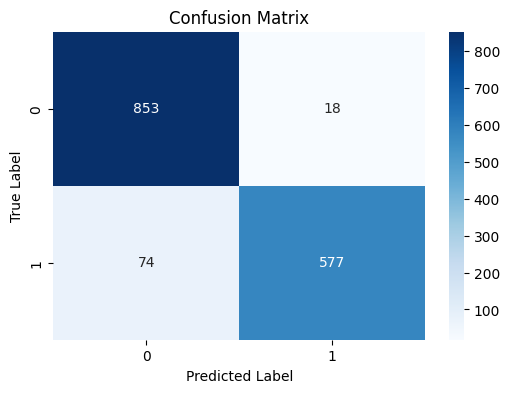

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


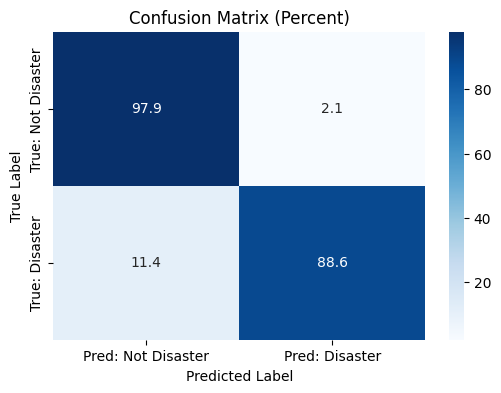

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(test_labels, predictions)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Pred: Not Disaster", "Pred: Disaster"],
            yticklabels=["True: Not Disaster", "True: Disaster"])

plt.title("Confusion Matrix (Percent)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


The confusion matrix shows strong overall performance, with most disaster tweets (label 1) correctly identified. Only 74 out of 651 were misclassified, resulting in our best recall for this class so far (0.89), marking a clear improvement over previous models.

In [ ]:
trainer.save_model("/content/drive/MyDrive/bertweet_disaster_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bertweet_disaster_model")


('/content/drive/MyDrive/bertweet_disaster_model/tokenizer_config.json',
 '/content/drive/MyDrive/bertweet_disaster_model/special_tokens_map.json',
 '/content/drive/MyDrive/bertweet_disaster_model/vocab.txt',
 '/content/drive/MyDrive/bertweet_disaster_model/bpe.codes',
 '/content/drive/MyDrive/bertweet_disaster_model/added_tokens.json')

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
model.save_pretrained("my-disaster-model")
tokenizer.save_pretrained("my-disaster-model")


('my-disaster-model/tokenizer_config.json',
 'my-disaster-model/special_tokens_map.json',
 'my-disaster-model/vocab.txt',
 'my-disaster-model/bpe.codes',
 'my-disaster-model/added_tokens.json')

In [ ]:
model.push_to_hub("disaster-tweet-classifier-bertweet")
tokenizer.push_to_hub("disaster-tweet-classifier-bertweet")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...zftwvgv/model.safetensors:   1%|1         | 5.53MB /  540MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/LenaGeller/disaster-tweet-classifier-bertweet/commit/6265a21a24ed4a2937d6f672c5784f5bebce8aee', commit_message='Upload tokenizer', commit_description='', oid='6265a21a24ed4a2937d6f672c5784f5bebce8aee', pr_url=None, repo_url=RepoUrl('https://huggingface.co/LenaGeller/disaster-tweet-classifier-bertweet', endpoint='https://huggingface.co', repo_type='model', repo_id='LenaGeller/disaster-tweet-classifier-bertweet'), pr_revision=None, pr_num=None)

We uploaded our fine-tuned model to the Hugging Face Hub.

## Gradio App

We successfully deployed a working web application for our disaster tweet classifier using Gradio and a fine-tuned BERTweet model hosted on Hugging Face. To run the app, simply execute the code in the notebook. It will launch a temporary public Gradio interface where you can test the model directly in your browser👇.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import gradio as gr

model_name = "LenaGeller/disaster-tweet-classifier-bertweet"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    label = "Disaster" if probs[0][1] > 0.5 else "Not Disaster"
    return label

iface = gr.Interface(fn=predict, inputs="text", outputs="text", title="Disaster Tweet Classifier")
iface.launch()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/771 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2c1674c99ecc9981e1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Conclusion

In this project, we explored various model architectures and approaches for classifying tweets as disaster-related or not. After experimenting with multiple models, we observed that **transformer-based** architectures delivered the most promising results.

The best performance was achieved using a model specifically pre-trained on social media text: **BERTweet**. Unlike general-purpose language models, BERTweet is trained on data from Twitter, capturing the informal, noisy, and highly contextual language typical of social media platforms. This domain-specific pretraining proved crucial, as the **linguistic patterns** in tweets differ significantly from standard written language.

Our results clearly show that using a transformer model adapted to the style and structure of social media significantly boosts performance, especially in detecting nuanced, context-dependent expressions related to disasters.